<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="right">
</p>

# ***용해탱크 시계열 데이터 AI 실습***

**제목:** 용해탱크의 품질 예측을 위한 AI 실습  <br>
**Description:** 용해탱크로부터 수집한 데이터를 전처리하고, 딥러닝 모델을 사용하여 품질 예측을 수행합니다

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터 및 예제를 수정한 교육자료입니다.

중소벤처기업부, Korea AI Manufacturing Platform(KAMP), 용해탱크 AI 데이터셋, KAIST(㈜ 임픽스, 한양대학교 산학협력단, ㈜아큐라소프트), 2020.12.14., www.kamp-ai.kr

https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=%EC%9A%A9%ED%95%B4%ED%83%B1%ED%81%AC&page=1&DATASET_SEQ=8&EQUIP_SEL=&GUBUN_SEL=&FILE_TYPE_SEL=&WDATE_SEL=

※ 분석하기에 앞서 다음과 같은 가상환경이 구축되어있는지 확인해주세요. <br>
Python 버전 : 3.10.12

In [1]:
!python --version

Python 3.10.12


## 1. 분석 개요

### 1.1 분석 배경

**공정(설비) 개요:**
- 용해공정은 분말 원재료를 액상 원재료에 녹이는 공정으로, 식품, 화학, 석유화학 등 다양한 분야에서 적용됩니다.
- 용해공정의 품질은 후공정 및 완제품의 품질에 큰 영향을 미치며, 균일한 혼합물이 되도록 하는 것이 중요합니다.

![melting_1.png](https://www.kamp-ai.kr/mnt/dataset/8/images/1.png)<br>
<center>[용해공정 설비(사진)]</center> <br>

**이슈사항(Pain Point):**
- 공정에서 설정한 기준값에 따라 운영하더라도 다양한 변수로 인해 품질이 변동됩니다.
- 작업자의 경험과 노하우에 의존하여 대처하는 경우가 많으며, 이로 인해 일관된 품질 관리가 어려운 경우가 있습니다.

### 1.2 분석 목표

**분석 목표:**
- 용해탱크의 운영 데이터를 통해 최종 제품의 품질을 예측합니다.
- 머신러닝 모델을 사용하여 공정 중 발생할 수 있는 불량을 예측하고, 이를 통해 품질을 개선하고자 합니다.

**제조 데이터 분석 기대효과:**
- 데이터 분석을 통해 설비 운영 조건에 따른 생산 품질을 예측하고, 불량률을 낮추기 위한 최적의 운영 조건을 도출합니다.

### 1.3 제조데이터 소개

**데이터 수집 방법:**
 - 제조 분야 : 분무건조공법을 이용한 분말유크림 제조 
 - 제조 공정명 : 용해혼합
 - 수집장비 : PLC(설비데이터) 및 DBMS(품질데이터) 
 - 수집기간 : 2020년 3월 4일 ~ 2020년 4월 30일 (약 2개월) 
 - 수집주기 : 사이클타임 약 6초

**데이터 유형/구조:**<br>
![melting_2.png](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/44ee0db6-aed1-4593-b4a3-40788741af18)<br>

 - 데이터 크기, 데이터 수량: 7개 컬럼, 836,200개의 관측치
 - 데이터 속성 정의 표:<br>
![melting_3.png](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/2c4d4837-9854-4d80-bc71-f6a7b34d0822)<br>
 - 독립변수/종속변수 정의:<br>
 ![melting_4.png](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/cfe8ce2f-6ecd-43f4-8bea-bc96ed0810c4)<br>
 

## 2. 분석 실습


### 2-1. 라이브러리 / 데이터 불러오기

#### 필요한 라이브러리 설치 및 불러오기

In [2]:
!pip install --upgrade pip

In [3]:
!pip install tensorflow==2.16.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.0 scikit-learn==1.5.0 imbalanced-learn==0.9.0

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

In [35]:
# 시드 고정
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

#### 데이터 불러오기

In [3]:
data_path = './dataset/melting_tank.csv'  # 실제 데이터 경로로 변경하세요
data = pd.read_csv(data_path)

### 2-2. 데이터 특성 파악


#### 데이터 기본 구조 파악

In [4]:
print(data.head())

            STD_DT  NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP TAG
0  2020-03-04 0:00    0        489         116          631  3.19  OK
1  2020-03-04 0:00    1        433          78          609  3.19  OK
2  2020-03-04 0:00    2        464         154          608  3.19  OK
3  2020-03-04 0:00    3        379         212          606  3.19  OK
4  2020-03-04 0:00    4        798        1736          604  3.21  OK


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB
None


In [6]:
print(data.describe())

                 NUM      MELT_TEMP     MOTORSPEED    MELT_WEIGHT  \
count  835200.000000  835200.000000  835200.000000  835200.000000   
mean   417599.500000     509.200623     459.782865     582.962125   
std    241101.616751     128.277519     639.436413    1217.604433   
min         0.000000     308.000000       0.000000       0.000000   
25%    208799.750000     430.000000     119.000000     186.000000   
50%    417599.500000     469.000000     168.000000     383.000000   
75%    626399.250000     502.000000     218.000000     583.000000   
max    835199.000000     832.000000    1804.000000   55252.000000   

                INSP  
count  835200.000000  
mean        3.194853  
std         0.011822  
min         3.170000  
25%         3.190000  
50%         3.190000  
75%         3.200000  
max         3.230000  


#### 시간 정보 datetime 형태 변환 및 인덱스 지정

In [7]:
data['STD_DT'] = pd.to_datetime(data['STD_DT'])

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   STD_DT       835200 non-null  datetime64[ns]
 1   NUM          835200 non-null  int64         
 2   MELT_TEMP    835200 non-null  int64         
 3   MOTORSPEED   835200 non-null  int64         
 4   MELT_WEIGHT  835200 non-null  int64         
 5   INSP         835200 non-null  float64       
 6   TAG          835200 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 44.6+ MB
None


In [9]:
data = data.set_index(['STD_DT'])

In [10]:
print(data.head())

            NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT  INSP TAG
STD_DT                                                       
2020-03-04    0        489         116          631  3.19  OK
2020-03-04    1        433          78          609  3.19  OK
2020-03-04    2        464         154          608  3.19  OK
2020-03-04    3        379         212          606  3.19  OK
2020-03-04    4        798        1736          604  3.21  OK


#### Histogram 및 Plot 그리기

##### Histogram

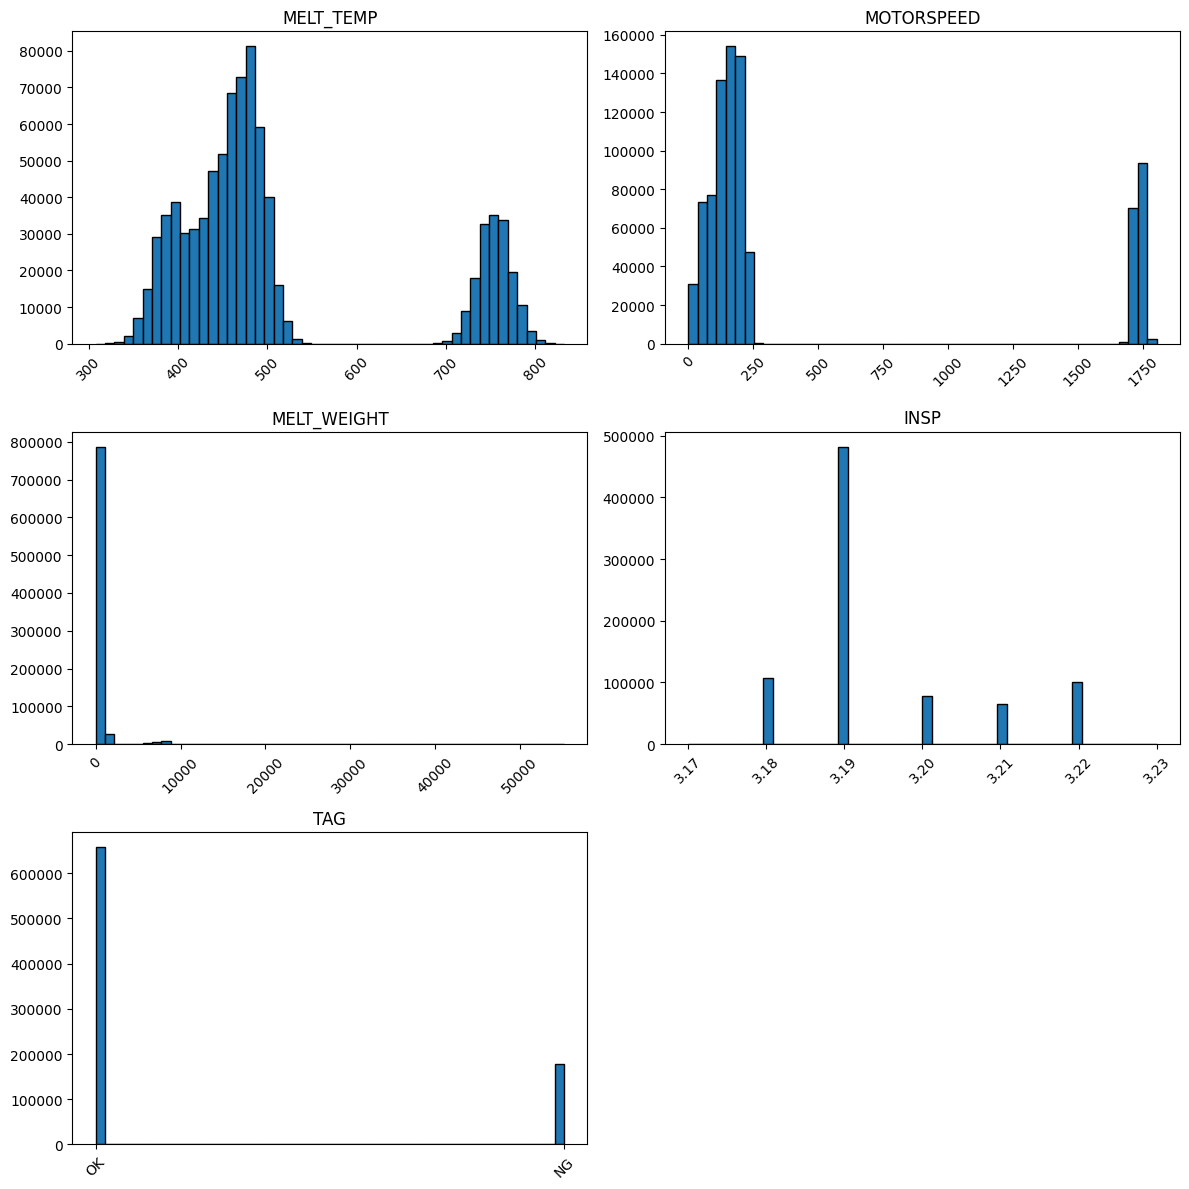

In [11]:
col_names = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']

# 반복문을 시작하기에 앞서 각 그래프의 사이즈를 12x12로 지정
plt.figure(figsize=(12, 12))

# 각 변수에 대해 히스토그램을 그리기 위한 반복문
for i in range(len(col_names)):
    plt.subplot(3, 2, i + 1)
    plt.hist(data[col_names[i]], bins=50, edgecolor='k')
    plt.xticks(rotation=45)
    plt.title(col_names[i])

plt.tight_layout()
plt.show()

##### Plot

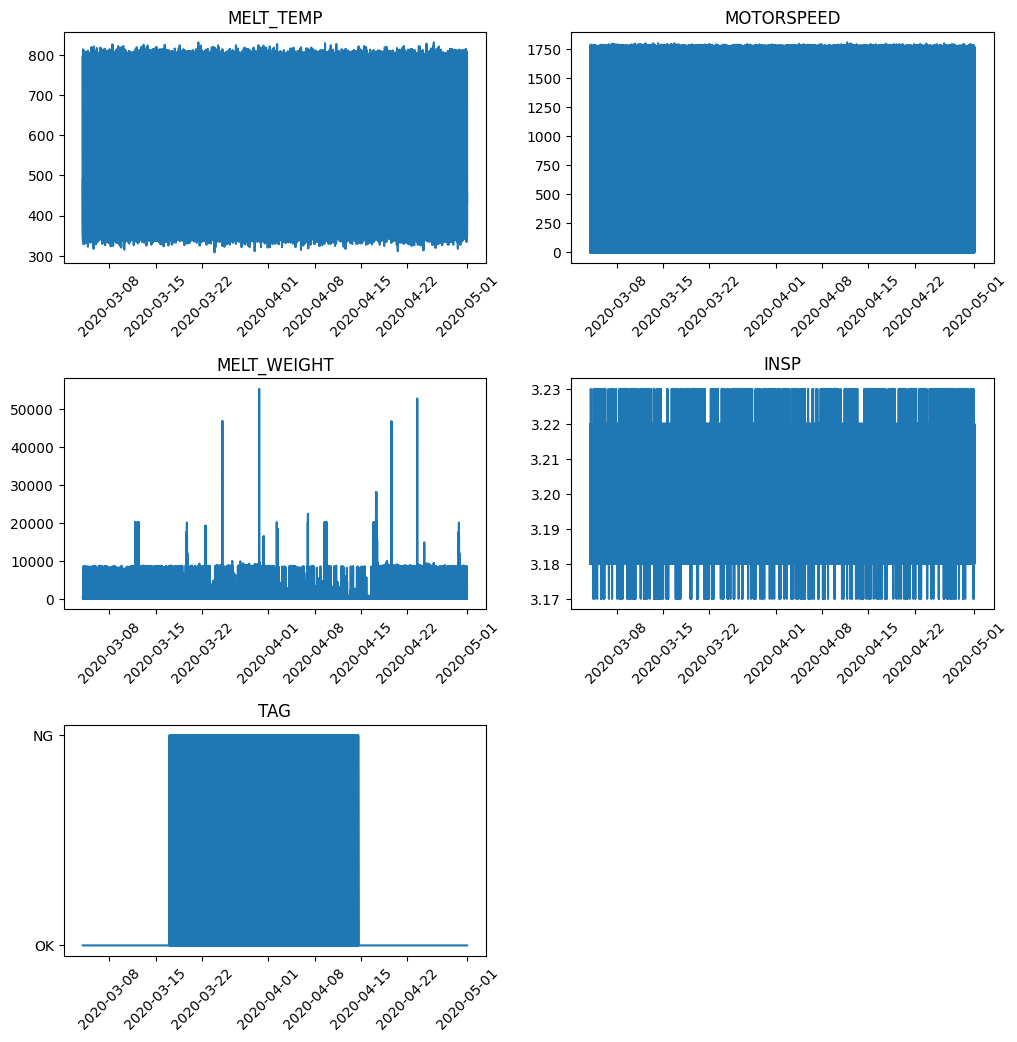

In [12]:
# 반복문을 시작하기에 앞서 각 그래프의 사이즈를 12x12로 지정
plt.figure(figsize=(12, 12))

# 각 변수에 대해 plot을 그리기 위한 반복문
for i in range(len(col_names)):
    plt.subplot(3, 2, i + 1)
    plt.plot(data[col_names[i]])
    plt.xticks(rotation=45)
    plt.title(col_names[i])

plt.subplots_adjust(hspace=0.5)
plt.show()

##### Plot(0:100 Slicing)

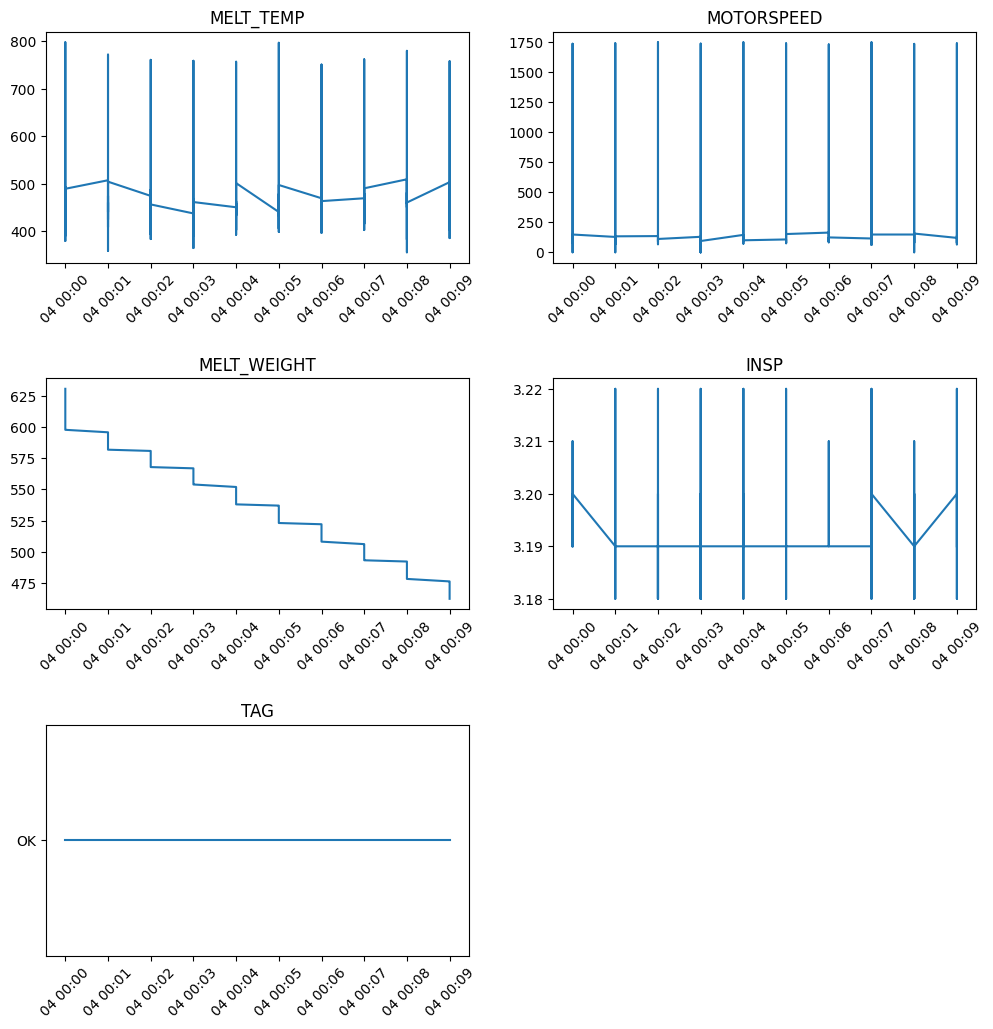

In [13]:
# 반복문을 시작하기에 앞서 각 그래프의 사이즈를 12x12로 지정
plt.figure(figsize=(12, 12))

# 각 변수에 대해 plot을 그리기 위한 반복문
for i in range(len(col_names)):
    plt.subplot(3, 2, i + 1)
    plt.plot(data[col_names[i]][0:100])
    plt.xticks(rotation=45)
    plt.title(col_names[i])

plt.subplots_adjust(hspace=0.5)
plt.show()

#### 범주형 변수 인코딩

In [14]:
label_encoder = LabelEncoder()
data['TAG'] = label_encoder.fit_transform(data['TAG'])

In [15]:
data['TAG'].value_counts()

TAG
1    658133
0    177067
Name: count, dtype: int64

#### 상관관계 확인

In [16]:
print(data.corr(method='pearson'))

                  NUM  MELT_TEMP  MOTORSPEED  MELT_WEIGHT      INSP       TAG
NUM          1.000000   0.000188   -0.000050     0.080079 -0.000524  0.086698
MELT_TEMP    0.000188   1.000000    0.944929    -0.000336  0.916295  0.310586
MOTORSPEED  -0.000050   0.944929    1.000000     0.000123  0.887813  0.264693
MELT_WEIGHT  0.080079  -0.000336    0.000123     1.000000 -0.000005 -0.012084
INSP        -0.000524   0.916295    0.887813    -0.000005  1.000000  0.272580
TAG          0.086698   0.310586    0.264693    -0.012084  0.272580  1.000000


### 2-3. 데이터 정제(전처리)


#### 분석에 활용할 칼럼 추출

In [17]:
data = data[['MELT_TEMP', 'MOTORSPEED', 'INSP', 'TAG']]

#### 훈련/테스트 데이터 분리

In [18]:
split_date = int(data.shape[0]*0.7)
train = data[:split_date]
test = data[split_date:]

In [19]:
train

,MELT_TEMP,MOTORSPEED,INSP,TAG
STD_DT,,,,
2020-03-04 00:00:00,489,116,3.19,1
2020-03-04 00:00:00,433,78,3.19,1
2020-03-04 00:00:00,464,154,3.19,1
2020-03-04 00:00:00,379,212,3.19,1
2020-03-04 00:00:00,798,1736,3.21,1
...,...,...,...,...
2020-04-13 14:23:00,748,1737,3.22,1
2020-04-13 14:23:00,381,216,3.19,1
2020-04-13 14:23:00,474,148,3.19,1


In [20]:
train.shape

(584640, 4)

In [21]:
test.shape

(250560, 4)

#### 정규화

Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling합니다.

1) data의 최대값(max)과 최소값(min)을 구한다.
2) 정규화할 데이터 값(x)과 앞서 구한 최대값(Xmax), 최소값(Xmin)을 다음의 식에 대입한다.<br>

<img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/c5a29097-0eb4-44a5-b379-2ea9df771095" width="400" height="400"/>

In [22]:
# 데이터 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

In [23]:
train_scaled

array([[0.34541985, 0.06430155, 0.33333333, 1.        ],
       [0.23854962, 0.04323725, 0.33333333, 1.        ],
       [0.29770992, 0.08536585, 0.33333333, 1.        ],
       ...,
       [0.31679389, 0.08203991, 0.33333333, 1.        ],
       [0.1870229 , 0.03769401, 0.16666667, 1.        ],
       [0.32251908, 0.05820399, 0.33333333, 1.        ]])

#### 독립변수(feature)와 종속변수(label) 분리

In [24]:
X_train_values = train_scaled[:, :-1]
y_train_values = train_scaled[:, -1]
X_test_values = test_scaled[:, :-1]
y_test_values = test_scaled[:, -1]

#### Window 정의 함수 생성

Window는 딥러닝을 학습하기 위한 단위로, window size는 timestep과 같다고 생각하면 된다. <br>
입력한 timestep만큼의 데이터를 저장하여 과거 값(예를들어, 1~10)을 통해 현재 종속변수를 예측하는 것이다.

(250550, 10, 3)

(250550,)

### 2-4. 모델 구축 및 훈련


**심층 신경망(DNN)**
- 심층 신경망(Deep Neural Network)은 여러 층의 노드로 구성된 신경망 구조를 쌓아 학습시키는 AI 알고리즘입니다.

    |<b>DNN의 기본구조</b> |
    | :--: |
    | ![](https://parallelr.com/uploads/2016/02/dnn_architecture.png)|
    | (출처:https://parallelr.com/2016/02/13/r-deep-neural-network-from-scratch/)|

  
- 각 노드는 입력 데이터를 받아 연산 후 결과를 출력하며, 활성화 함수(예: 시그모이드, ReLU)를 통해 비선형 변환을 수행합니다.

    |<b>활성화 함수 예: ReLU, sigmoid</b> |
    | :--: |
    | ![CNC_5](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/19863edd-d7a5-4d73-8462-cd238e520c82)|

- 학습은 경사 하강법을 통해 손실함수(loss function)를 최소화하는 방향으로 진행되며, 분류 문제에서는 주로 이진 교차 엔트로피(binary crossentropy)를 사용합니다.

    |<b>이진 교차 엔트로피(binary crossentropy)</b> |
    | :--: |
    | ![CNC_6](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/e73cdb2d-da9f-49e9-a414-d364a87bff2c)|



### DNN 모델 구축
- 시계열 형태의 데이터를 DNN 모델을 학습하기위해서는 Flatten이 필요합니다


|<b>Flatten</b> |
| :--: |
| 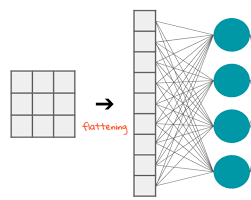|

c:\Users\Han\Miniconda3\envs\hyundai_eqip_test\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Han\Miniconda3\envs\hyundai_eqip_test\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 학습

Epoch 1/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.7130 - loss: 0.5295
Epoch 2/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.7289 - loss: 0.4815
Epoch 3/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.7315 - loss: 0.4785
Epoch 4/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.7316 - loss: 0.4768
Epoch 5/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7309 - loss: 0.4758
Epoch 6/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.7307 - loss: 0.4749
Epoch 7/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.7303 - loss: 0.4741
Epoch 8/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.7306 - loss: 0.4731
Epoch 9/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.7310 - loss: 0.4720
Epoch 10/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.7314 - loss: 0.4708
Epoch 11/30
571/571 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.7318 - loss: 0.4697
Epoch 12/30
571/571 ━━━━━━━━━━

#### 손실 그래프 시각화

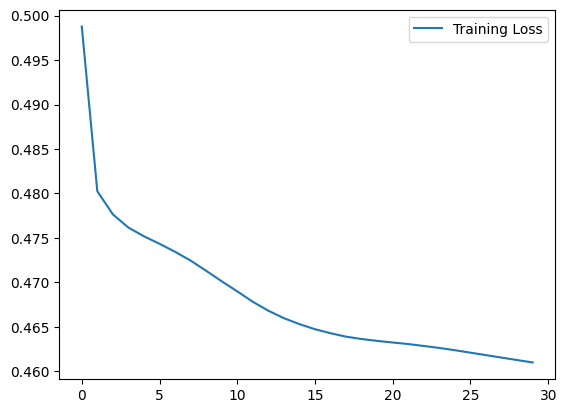

### 2-5. 모델 평가


7830/7830 ━━━━━━━━━━━━━━━━━━━━ 4s 556us/step
              precision    recall  f1-score   support

         0.0       0.04      0.87      0.08      2940
         1.0       1.00      0.77      0.87    247610

    accuracy                           0.77    250550
   macro avg       0.52      0.82      0.48    250550
weighted avg       0.99      0.77      0.86    250550

[[  2553    387]
 [ 56285 191325]]


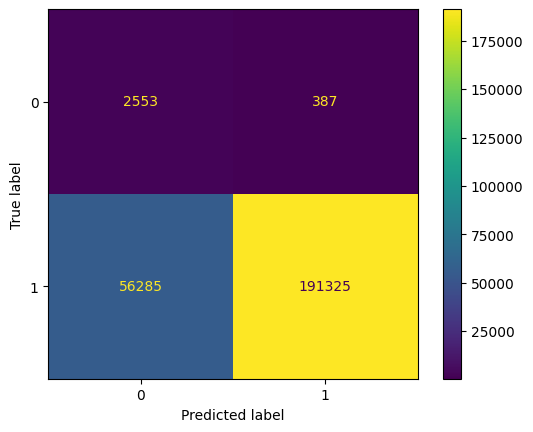

Accuracy: 0.7738
F1 Score: 0.8618
